# **Previsão de Contrato de Seguros**

Author: Arthur Felipe Thamay

Descrição do problema:

Nosso cliente é uma seguradora que provê seguro saúde para seus clientes. Eles precisam de sua ajuda na construção de um modelo para identificar se os segurados (clientes) do ano anterior também terão interesse no seguro automóvel oferecido pela empresa.

Uma apólice de seguro é um acordo pelo qual uma empresa se compromete a fornecer uma garantia de compensação por perdas, danos, doenças ou morte especificados em troca do pagamento de uma taxa especificada, isto é, uma quantia que o cliente precisa pagar regularmente a uma seguradora por essa garantia. Assim como o seguro médico, existe o seguro de veículos em que todos os anos o cliente precisa pagar uma taxa de determinado valor à seguradora para que, em caso de acidente com o veículo, a seguradora forneça uma indenização para o consumidor.

Construir um modelo para prever se um cliente estaria interessado em seguro de veículos é extremamente útil para a empresa pois ela pode planejar sua estratégia de comunicação para chegar a esses clientes e otimizar seu modelo de negócios e receita.

Descrição dos dados:



*   **Id**: ID única do segurado
*   **Gender**: Gênero do segurado
*   **Age**: Idade do segurado
*   **Driving_License**: Booleano indicando se o segurado possui habilitação
*   **Region_Code**: Código para a região do segurado
*   **Previously_Insured**: Booleano indicando se o segurado possuiu seguro do veículo no passado
*   **Vehicle_Age**: Idade do Veículo
*   **Vehicle_Damage**: Booleano indicando se o veículo sofreu danos no passado
*   **Annual_Premium**: Taxa paga anualmente
*   **PolicySalesChannel**: Código anonimizado indicando o canal de contato com o segurado (correspondência, telefone, pessoalmente, etc)
*   **Vintage**: Tempo em dias que o segurado é cliente da empresa
*   **Response**: Variável alvo. Booleano indicando se o segurado possui ou não interesse no seguro veículo.

**As atividades esperadas para essa etapa são descritas a seguir:**


1.   Realize uma análise exploratória nos dados, identificando e explorando:
*   Checar distribuição das variáveis, realizando normalização caso julgue necessário;
*   Correlações entre as variáveis;
*   Checar distribuição das classes, realizando balanceamento caso julgue necessário.

2.   Tune, usando validação cruzada e outras medidas para controlar o overfitting caso necessário:
*   Um modelo de classificação com Regressão Logística,
*   Um modelo de classificação com Árvores de Decisão,
*   Um modelo de Boosting, e
*   Um quarto modelo, escolhido na API do Scikit-Learn.

3.   Identifique os valores de Precision, Recall, Acurácia e F1-Score para os modelos utilizados. Existe diferença entre o desempenho no treino e na validação? Justifique os resultados obtidos.

4.   Re-treine o melhor modelo (usando os melhores valores de parâmetros encontrados em todos os dados, sem usar validação cruzada). Use esse último modelo treinado para prever os dados de teste. Reporte os resultados encontrados.

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(42)

from matplotlib import pyplot as plt

sns.set_style('dark')
 

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## **Carregando os dados**

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1MfFf_EwMsdtJXu6qhQCAPnVCDkYMu1l8')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df.shape

(381109, 12)

In [ ]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
df['Response'].unique()

array([1, 0])

## **Sumário dos Dados**

Inicialmente vamos identificar nossas variáveis, por meio da biblioteca do Pandas, na qual gera estatísticas descritivas, resumindo a tendência central, a dispersão e a forma da distribuição de um conjunto de dados. 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


## **Data Analysis**

Vamos analisar a correlação.

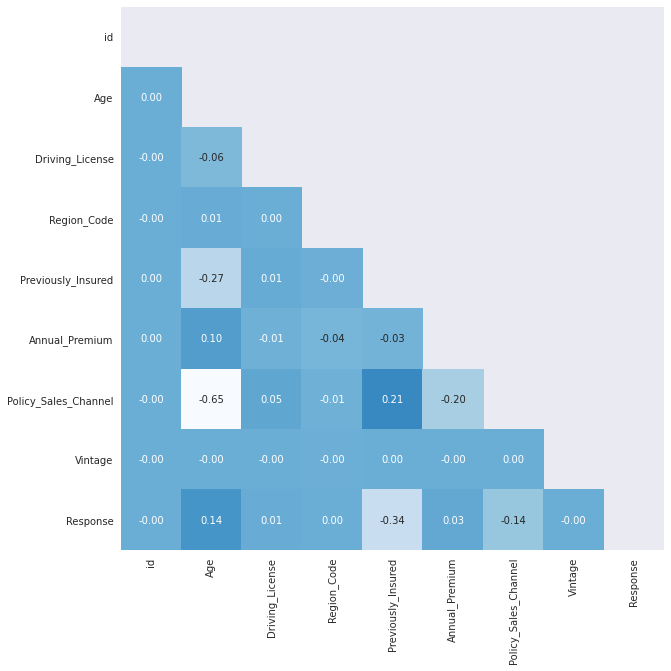

In [ ]:
corr = df.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 10)
sns.heatmap(corr, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Blues, center=0)

Além disso, vamos observar através de um gráfico de dispersão, a relação de cada atributo com a saída:

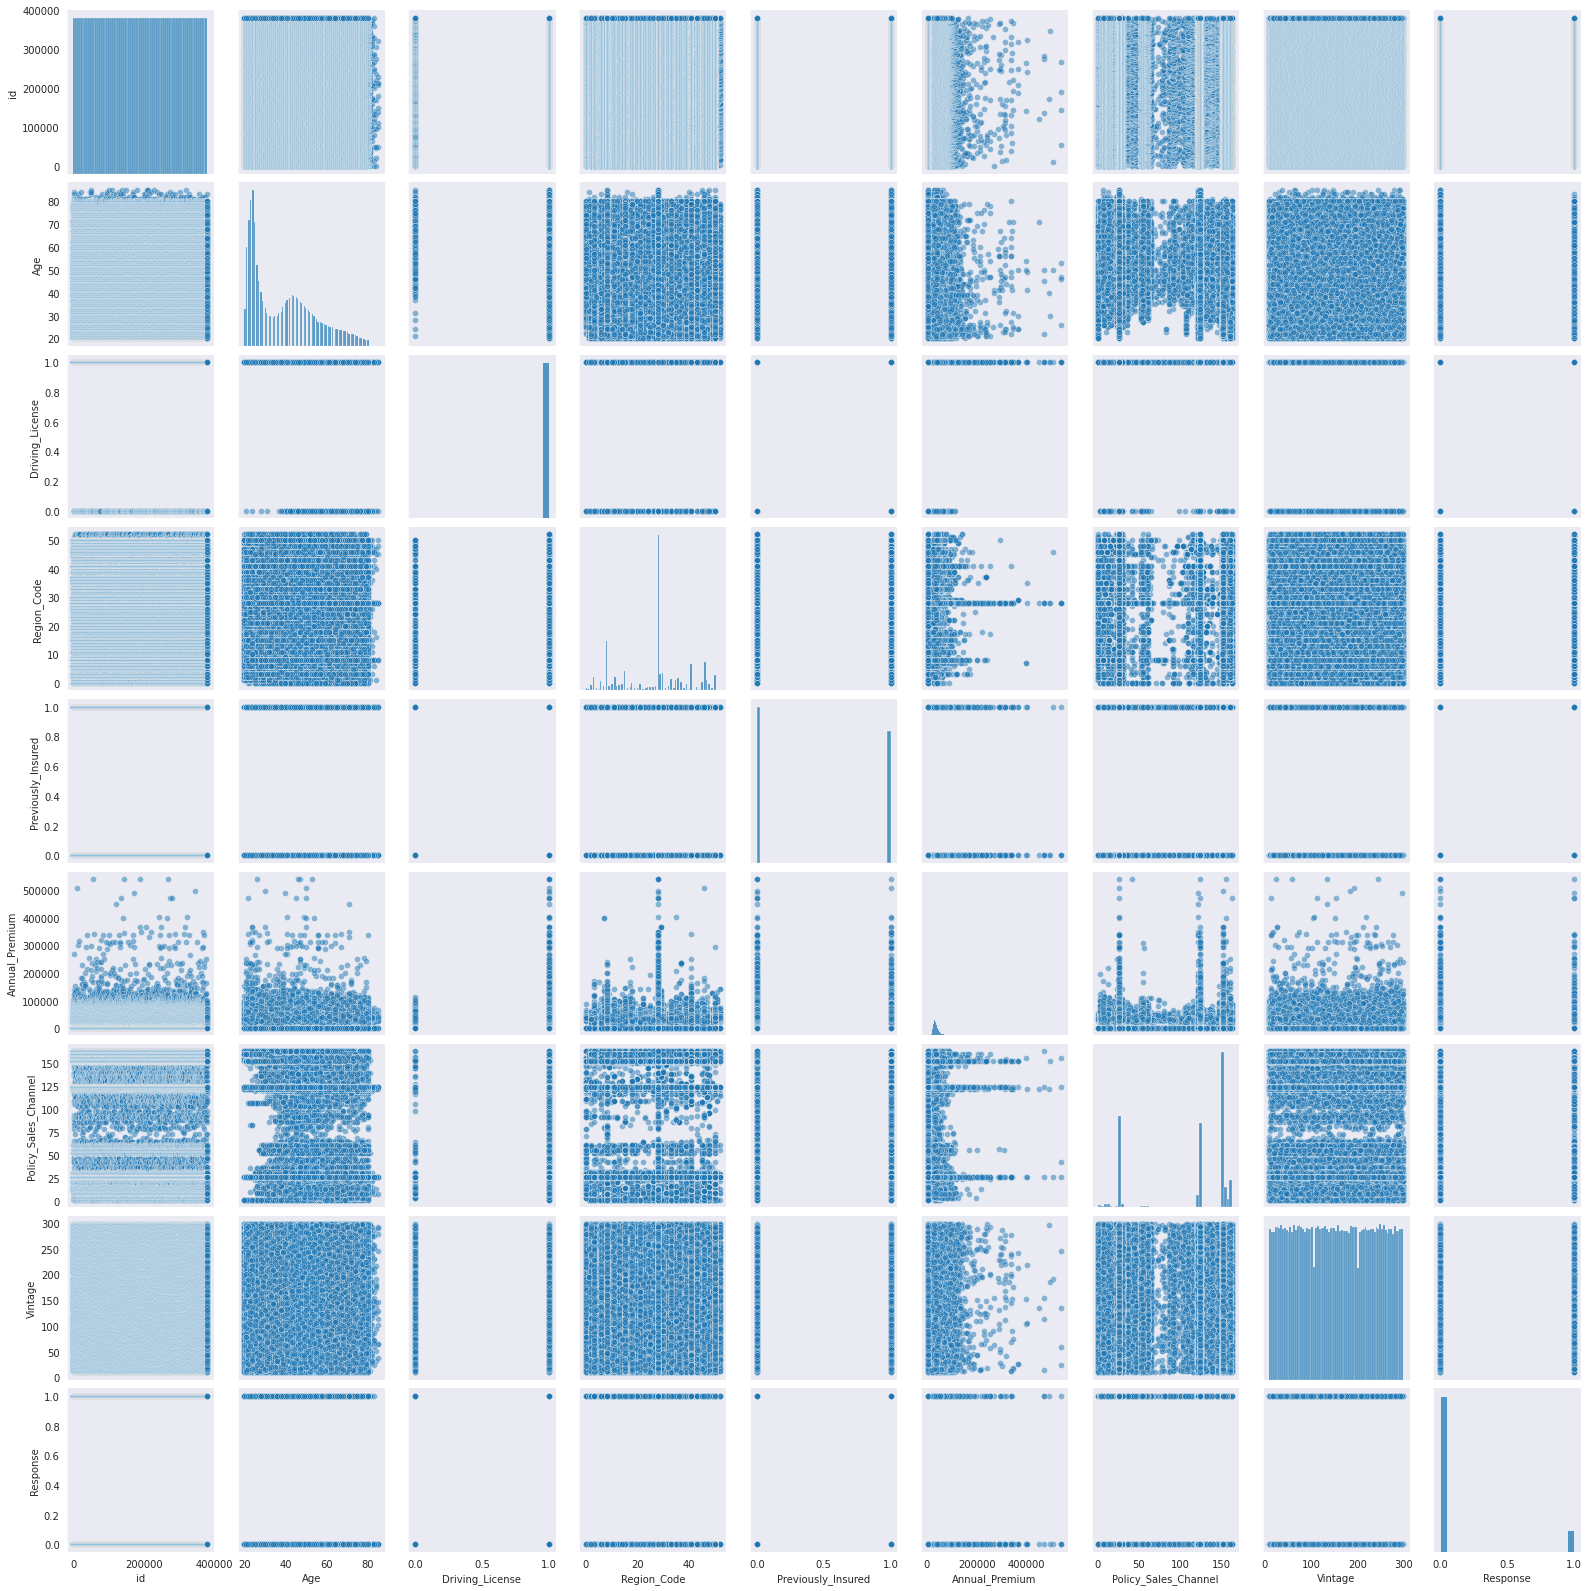

In [ ]:
sns.pairplot(df, plot_kws = {'alpha': 0.5})
plt.show()

### Análise exploratória

Vamos verificar o balanceamento entre as variaveis response.

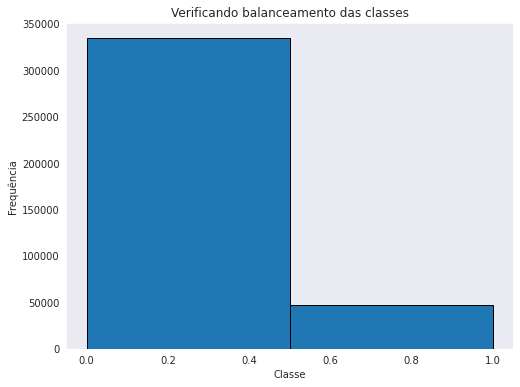

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(df['Response'], bins=2, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

Tomando como base em que, a váriável "Response" é booleana, sendo assim 0 corresponde a "false" e 1 corresponde a "true". Consequentemente existem muito mais pessoas interessadas em renovar o seguro (1) do que não renovar (0). Dessa forma, realizamos um procedimento chamado `UnderSampling`, onde reduzimos o número de amostras de uma classe, para que o dataset fique mais balanceado.

In [ ]:
n_samples = int(1.5 * len(df[df['Response'] == 1]))
balanced_df = pd.concat([df[df['Response'] == 1],
                        df[df['Response'] == 0].sample(n_samples)],
                        ignore_index=True).reset_index(drop=True)

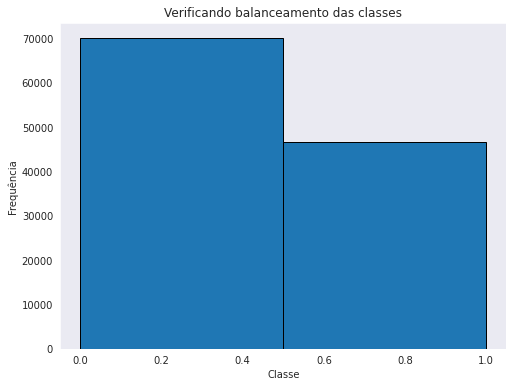

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(balanced_df['Response'], bins=2, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

In [ ]:
balanced_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
2,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
3,11,Female,47,1,35.0,0,1-2 Year,Yes,47576.0,124.0,46,1
4,16,Male,37,1,6.0,0,1-2 Year,Yes,2630.0,156.0,147,1


## **Manipulação dos dados**

Inicialmente, transformamos as colunas textuais em colunas numéricas.

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['Gender'].tolist())
balanced_df['Gender'] = labels

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['Vehicle_Damage'].tolist())
balanced_df['Vehicle_Damage'] = labels

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['Vehicle_Age'].tolist())
balanced_df['Vehicle_Age'] = labels

In [ ]:
balanced_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
2,8,0,56,1,28.0,0,0,1,32031.0,26.0,72,1
3,11,0,47,1,35.0,0,0,1,47576.0,124.0,46,1
4,16,1,37,1,6.0,0,0,1,2630.0,156.0,147,1


Vamos verificar os tipos de nossas variáveis.

In [ ]:
balanced_df.dtypes

id                        int64
Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Tendo em vista que o objetivo da normalização é alterar os valores das colunas numéricas no dataframe para uma escala comum, sem distorcer as diferenças nos intervalos de valores, normalizamos nosso conjunto de dados pelo fato de que alguns dps nossos parâmetros terem intervalos muito diferentes.

In [ ]:
scaler = MinMaxScaler()
transformed = scaler.fit_transform(balanced_df.drop(['Response'], axis=1))
transformed_df = pd.DataFrame(transformed)
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,1.0,0.369231,1.0,0.538462,0.0,1.0,1.0,0.070366,0.154321,0.716263
1,0.000005,1.0,0.415385,1.0,0.538462,0.0,1.0,1.0,0.066347,0.154321,0.058824
2,0.000018,0.0,0.553846,1.0,0.538462,0.0,0.0,1.0,0.054696,0.154321,0.214533
3,0.000026,0.0,0.415385,1.0,0.673077,0.0,0.0,1.0,0.083615,0.759259,0.124567
4,0.000039,1.0,0.261538,1.0,0.115385,0.0,0.0,1.0,0.000000,0.956790,0.474048


## **Treinando os modelos**

Na etapa de classificação vamos separar os dados entre treino, teste e validação. Entretanto, a validação será feita utilizando Cross Validation. 

Além disso, aplicaremos uma última transformação nos dados: criaremos um novo vetor para conter nossa variável alvo (Response), teremos 0 para "Não Interesse" em renovar o seguro e 1 para "Interesse" em renovar.


In [ ]:
y = pd.Series([0 if sm == 0 else 1 for sm in balanced_df['Response']])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(transformed_df, y)

In [ ]:
folds = 10
kfold = StratifiedKFold(folds)

Para validação cruzada o sklearn dispoe de basicamente 3 funções:

*   cross_val_score: Avalia uma pontuação por validação cruzada
*   cross_validate: Executa a validação cruzada em várias métricas e também para retornar pontuações de treino, tempos de ajuste e tempos de pontuação
*   cross_val_predict: Obtem previsões de cada divisão da validação cruzada para fins de diagnóstico.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

In [ ]:
def get_model_fit(metrics):
    model = metrics['estimator'][0]
    metrics.pop('estimator')
    return model

In [ ]:
def print_metrics_models(metrics):
    for key in metrics.keys():
        print(key, " = ", metrics.get(key, 0).mean())

In [ ]:
def vis_metrics_model(metrics):
    metrics_vis = metrics
    
    for key in ['fit_time', 'score_time']:
        metrics_vis.pop(key) 
    
    x = [key for key in metrics_vis.keys()]
    y = [metrics_vis.get(key, 0).mean() for key in metrics_vis.keys()]
    
    sns.set(rc={'figure.figsize':(12,5)})
    ax = sns.barplot(x=x, y=y, palette='rocket')
    ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [ ]:
scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

accuracy = 'accuracy'
precision = 'precision'
f1 = 'f1'
cv = 5

### Regressão Logística

Definimos no array `logreg_C` os possíveis valores para o parâmetro `C` da regressão logística. Esse parâmetro se refere a força da regularização.
Utilizamos o KFold feito manualmente e posteriormente declaramos algumas variáveis para manter os valores atuais da melhor predição.
A ideia é testar os diferentes valores de C e re-treinar o modelo com o C que obteve menor erro de validação.

In [ ]:
logreg_C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_c = logreg_C[0]
best_score = 0
best_accuracy = 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    for train_index, test_index in kfold.split(x_train, y_train):
        x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model = LogisticRegression(C=c, random_state=31)
        model.fit(x_train_fold, y_train_fold)
        pred = model.predict(x_test_fold)

        score += f1_score(y_test_fold, pred)
        accuracy += accuracy_score(y_test_fold, pred)


    score = score / folds # média
    avg_scores.append(score)
    accuracy = accuracy / folds
    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 0.001. Resultou no F1 0.7527778409728195 e Acurácia 0.747822030755773 durante o 10-fold


Re-treinamos o modelo com todos os dados e avaliamos no conjunto de testes

In [ ]:
model = LogisticRegression(C = best_c)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [ ]:
f1 = f1_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.7517829767379857 e Acurácia 0.7448790847434404


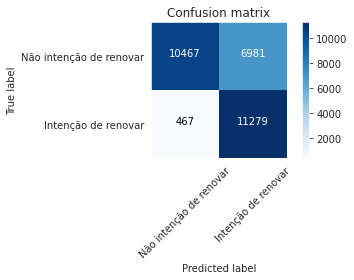

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, ['Não intenção de renovar', 'Intenção de renovar'])

A matriz de confusão acima pode ser lida da seguinte forma:
* Na diagonal principal, temos os casos em que a regressão logística foi efetiva; de modo que:
    * O primeiro quadrado da primeira linha representa um verdadeiro negativo, onde a regressão logística funcionou e mostrou que a previsão de não renovar foi realizada.
    * O segundo quadrado da segunda linha representa um verdadeiro positivo, onde a regressão logística funcionou e mostrou que a previsão foi mantida e o seguro foi renovado.

* Fora da diagonal, temos as previsões incorretas da regressão logística, de modo que:
    * O segundo quadrado da primeira linha representa os falsos positivos, ou seja, os casos em que a regressão indicava que os clientes iriam renovar, mas neste caso, o modelo foi falho.
    * O primeiro quadrado da segunda linha representa os falsos negativos, isto é, aqueles que renovaram mesmo após a regressão linear apontar que não iriam renovar;

Avaliando os resultados, quando fizemos o balanceamento entre as classes, deixamos a classe de Intenção de renovar com mais elementos que a classe de falha, em torno de 60/40. Com isso tivemos uma boa previsão, no que diz respeito a intenção de renovar o seguro em relação a não renovar.

Por fim, podemos ver como os diferentes valores de C impactaram na performance do modelo em termos de F1-score:

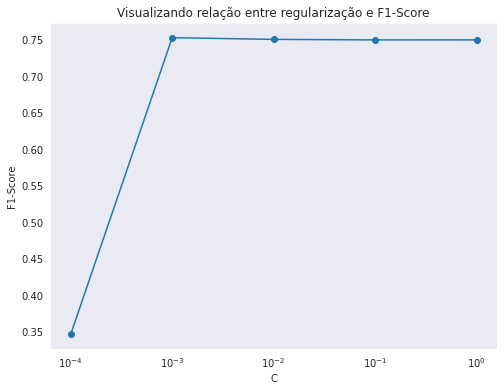

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(logreg_C, avg_scores, '-o')
plt.title('Visualizando relação entre regularização e F1-Score')
plt.xlabel('C')
plt.ylabel('F1-Score')
plt.xscale('log')
plt.show()

### Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Adicionando parâmetro para indicar que as classes não estão balanceadas class_weight='balanced'

In [ ]:
model_dtc = DecisionTreeClassifier(random_state=0, class_weight='balanced')

In [ ]:
%%time
metrics_dtc = cross_validate(model_dtc, x_train_fold, y_train_fold, 
                             scoring=scoring, cv=cv, 
                             return_train_score=True,
                             return_estimator=True)

CPU times: user 3.13 s, sys: 6.8 ms, total: 3.14 s
Wall time: 3.15 s


In [ ]:
sorted(metrics_dtc.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_accuracy',
 'train_f1',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [ ]:
model_dtc = get_model_fit(metrics_dtc)
model_dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
print_metrics_models(metrics_dtc)

fit_time  =  0.4812771320343018
score_time  =  0.030922460556030273
test_accuracy  =  0.7061771210994905
train_accuracy  =  1.0
test_f1  =  0.6267914436647183
train_f1  =  1.0
test_recall  =  0.6180242183538931
train_recall  =  1.0
test_precision  =  0.6358646442207468
train_precision  =  1.0
test_roc_auc  =  0.6913898939937557
train_roc_auc  =  1.0


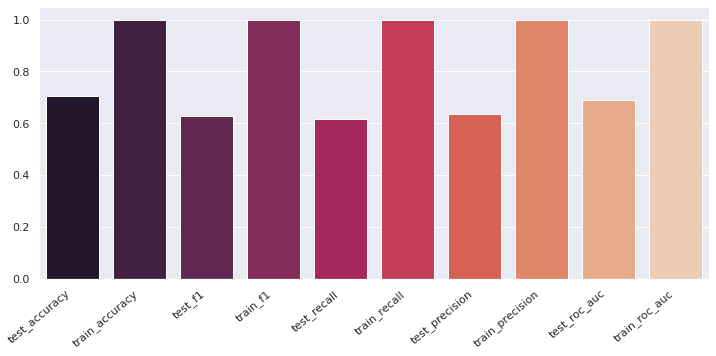

In [ ]:
vis_metrics_model(metrics_dtc)

* A acurácia se refere à proximidade entre o valor obtido de treino e o valor de teste. Como resultado, obteve-se um valor de para teste de 0.71 e 1.0 para o valor de treino. 
* A precisão é o grau de variação de resultados de uma amostra, tendo como base o desvio-padrão. Obtivemos um resultado de 0.64 de treino e 1.0 de teste.
* Recall é a frequência em que o seu classificador encontra os exemplos de uma classe, ou seja, o numero de verdadeiros positivos e verdadeiros negativos. Os resultados de recall froma de 0.62 para teste e 1.0 para treino.
* F1-Score faz uma combinação entre precisão e recall, em relação ao quanto o classificador atinge resultados verdadeiros e o quanto a variabilidade dos ddos é pequena, tornando o modelo mais confiável. Como resultados, obtivemos os valores de 0.63 para teste e de 1.0 para treino.
* Em geral, os resultados obtidos apresentam um overfitting, onde para os dados de treino atingimos o valor máximo, porém para o teste em alguns casos o valor vai para quase a metade, como é o caso do Recall, F1-score e Precisão. Nesse modelo temos uma diferença muito mais expressiva entre resultados de treino e teste.

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=100)
model_ada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [ ]:
metrics_ada = cross_validate(model_ada, x_train_fold, y_train_fold, 
                            scoring=scoring, cv=cv, 
                             return_train_score=True,
                             return_estimator=True)

In [ ]:
sorted(metrics_ada.keys())


['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_accuracy',
 'train_f1',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [ ]:
def get_model_fit(metrics):
    model = metrics['estimator'][0]
    metrics.pop('estimator')
    return model
    
model_ada = get_model_fit(metrics_ada)
model_ada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [ ]:
def vis_metrics_model(metrics):
    metrics_vis = metrics
    
    for key in ['fit_time', 'score_time']:
        metrics_vis.pop(key) 
    
    x = [key for key in metrics_vis.keys()]
    y = [metrics_vis.get(key, 0).mean() for key in metrics_vis.keys()]
    
    sns.set(rc={'figure.figsize':(12,5)})
    ax = sns.barplot(x=x, y=y, palette='rocket')
    ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
def print_metrics_models(metrics):
    for key in metrics.keys():
        print(key, " = ", metrics.get(key, 0).mean())

print_metrics_models(metrics_ada)

fit_time  =  28.24340763092041
score_time  =  0.5515885829925538
test_accuracy  =  0.7100972841321964
train_accuracy  =  1.0
test_f1  =  0.6409587232208842
train_f1  =  1.0
test_recall  =  0.6481819773318324
train_recall  =  1.0
test_precision  =  0.6339436881725936
train_precision  =  1.0
test_roc_auc  =  0.7921634693937045
train_roc_auc  =  1.0


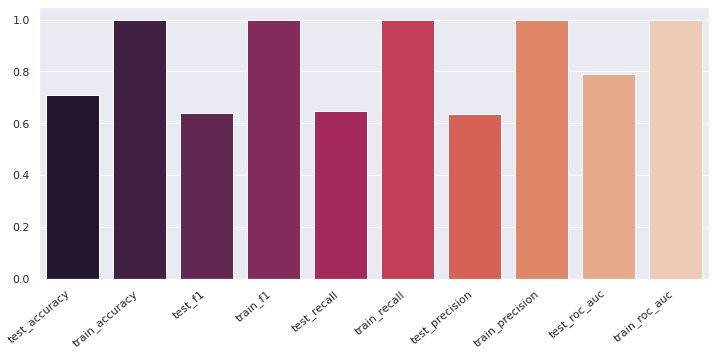

In [ ]:
vis_metrics_model(metrics_ada)


* A acurácia obteve-se um valor de para teste de 0.71 e 1.0 para o valor de treino. 
* A precisão obteve um resultado de 0.63 de treino e 1.0 de teste.
* Recall apresentou resultados de 0.65 para teste e 1.0 para treino.
* F1-Score obteve resultados de 0.64 para teste e de 1.0 para treino.
* Os resultados obtidos apresentam um overfitting, como os apresentados no modelo anterior. Nesse modelo observa-se que os valores para F1-Score, Precisão e Recall de teste, estão próximos o que denota um certo equilíbrio na classificação.

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=3)

metrics_knn = cross_validate(model_knn, x_train_fold, y_train_fold, 
                             scoring=scoring, cv=cv, 
                             return_train_score=True,
                             return_estimator=True)


In [ ]:
sorted(metrics_knn.keys())


['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_accuracy',
 'train_f1',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [ ]:
model_knn = get_model_fit(metrics_knn)
model_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
print_metrics_models(metrics_knn)

fit_time  =  3.4754441738128663
score_time  =  6.633382511138916
test_accuracy  =  0.7258541564511689
train_accuracy  =  0.8526540460178023
test_f1  =  0.669162723888728
train_f1  =  0.8217754943695745
test_recall  =  0.69445146909441
train_recall  =  0.8508961546602875
test_precision  =  0.6456662236531872
train_precision  =  0.7945833653102425
test_roc_auc  =  0.7898607259980751
train_roc_auc  =  0.9319631068266256


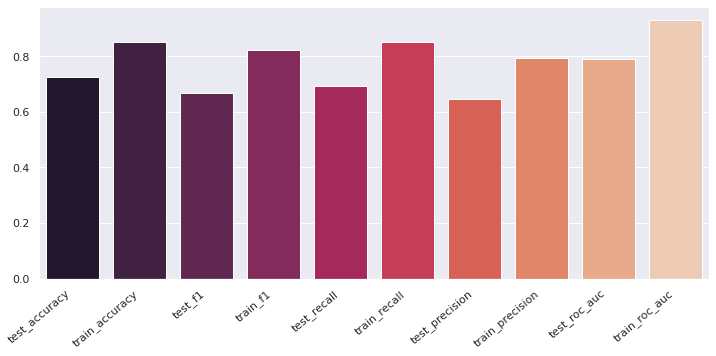

In [ ]:
vis_metrics_model(metrics_knn)

* A acurácia obteve-se um valor de para teste de 0.83 e 0.85 para o valor de treino. 
* A precisão obteve um resultado de 0.65 de treino e 0.79 de teste.
* Recall apresentou resultados de 0.69 para teste e 0.85 para treino.
* F1-Score obteve resultados de 0.67 para teste e de 0.82 para treino.
* Em geral, os valores de acurácia foram os mais altos e mais próximos entre treino e teste.

## **Retreinando os modelos**

### Regressão Logística

In [ ]:
logreg_C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_c = logreg_C[0]
best_score = 0
best_accuracy = 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    for train_index, test_index in kfold.split(x_train_fold, y_train_fold):
        x_train_fold_two, x_test_fold_two = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold_two, y_test_fold_two = y_train.iloc[train_index], y_train.iloc[test_index]

        model = LogisticRegression(C=c, random_state=31)
        model.fit(x_train_fold_two, y_train_fold_two)
        pred = model.predict(x_test_fold_two)

        score += f1_score(y_test_fold_two, pred)
        accuracy += accuracy_score(y_test_fold_two, pred)


    score = score / folds # média
    avg_scores.append(score)
    accuracy = accuracy / folds
    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 0.001. Resultou no F1 0.7528642645164081 e Acurácia 0.7515066113928381 durante o 10-fold


In [ ]:
model = LogisticRegression(C = best_c)
model.fit(x_train_fold, y_train_fold)
pred = model.predict(x_test)

In [ ]:
f1 = f1_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.7515228596291585 e Acurácia 0.7457011714735905


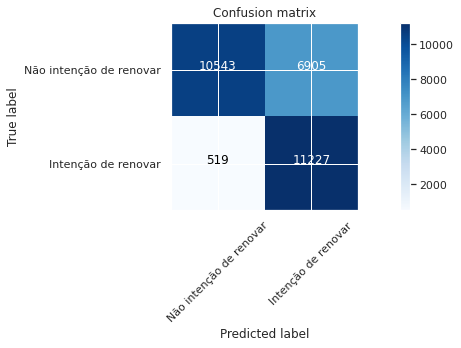

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, ['Não intenção de renovar', 'Intenção de renovar'])

A matriz de confusão acima pode ser lida da seguinte forma:
* Na diagonal principal, temos os casos em que a regressão logística foi efetiva; de modo que:
    * O primeiro quadrado da primeira linha representa um verdadeiro negativo, onde a regressão logística funcionou e mostrou que a previsão de não renovar foi realizada.
    * O segundo quadrado da segunda linha representa um verdadeiro positivo, onde a regressão logística funcionou e mostrou que a previsão foi mantida e o seguro foi renovado.

* Fora da diagonal, temos as previsões incorretas da regressão logística, de modo que:
    * O segundo quadrado da primeira linha representa os falsos positivos, ou seja, os casos em que a regressão indicava que os clientes iriam renovar, mas neste caso, o modelo foi falho.
    * O primeiro quadrado da segunda linha representa os falsos negativos, isto é, aqueles que renovaram mesmo após a regressão linear apontar que não iriam renovar;

Avaliando os resultados, quando fizemos o balanceamento entre as classes, deixamos a classe de Intenção de renovar com mais elementos que a classe de falha, em torno de 60/40. Com isso tivemos uma boa previsão, no que diz respeito a intenção de renovar o seguro em relação a não renovar.

Por fim, podemos ver como os diferentes valores de C impactaram na performance do modelo em termos de F1-score:

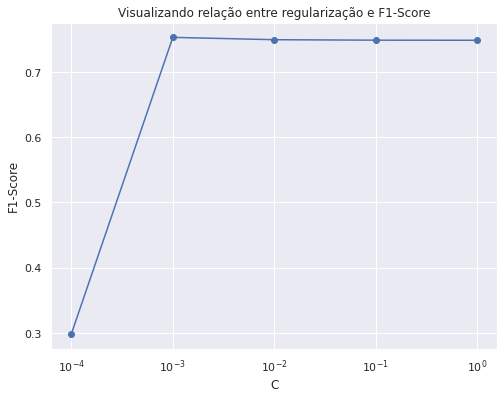

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(logreg_C, avg_scores, '-o')
plt.title('Visualizando relação entre regularização e F1-Score')
plt.xlabel('C')
plt.ylabel('F1-Score')
plt.xscale('log')
plt.show()

### Árvore de Decisão

In [ ]:
%%time
metrics_dtc = cross_validate(model_dtc, x_train_fold_two, y_train_fold_two, 
                             scoring=scoring, cv=cv, 
                             return_train_score=True,
                             return_estimator=True)

CPU times: user 2.78 s, sys: 8.01 ms, total: 2.79 s
Wall time: 2.8 s


In [ ]:
sorted(metrics_dtc.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_accuracy',
 'train_f1',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [ ]:
model_dtc = get_model_fit(metrics_dtc)
model_dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
print_metrics_models(metrics_dtc)

fit_time  =  0.4268056392669678
score_time  =  0.02779278755187988
test_accuracy  =  0.7043178041305242
train_accuracy  =  1.0
test_f1  =  0.6261149681828647
train_f1  =  1.0
test_recall  =  0.6201542390334146
train_recall  =  1.0
test_precision  =  0.6322392685005467
train_precision  =  1.0
test_roc_auc  =  0.6902009892146945
train_roc_auc  =  1.0


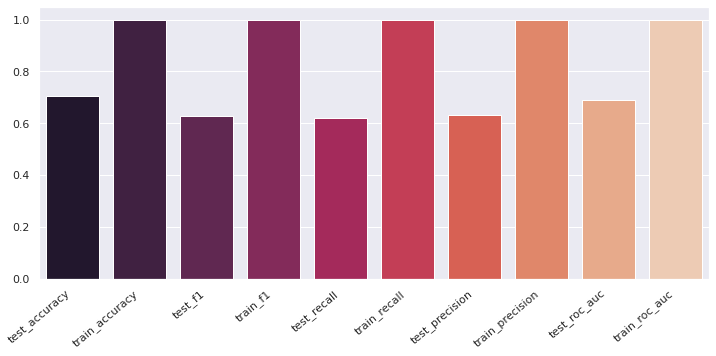

In [ ]:
vis_metrics_model(metrics_dtc)

* A acurácia se refere à proximidade entre o valor obtido de treino e o valor de teste. Como resultado, obteve-se um valor de para teste de 0.71 e 1.0 para o valor de treino. 
* A precisão é o grau de variação de resultados de uma amostra, tendo como base o desvio-padrão. Obtivemos um resultado de 0.64 de treino e 1.0 de teste.
* Recall é a frequência em que o seu classificador encontra os exemplos de uma classe, ou seja, o numero de verdadeiros positivos e verdadeiros negativos. Os resultados de recall froma de 0.62 para teste e 1.0 para treino.
* F1-Score faz uma combinação entre precisão e recall, em relação ao quanto o classificador atinge resultados verdadeiros e o quanto a variabilidade dos ddos é pequena, tornando o modelo mais confiável. Como resultados, obtivemos os valores de 0.63 para teste e de 1.0 para treino.
* Em geral, os resultados obtidos de reteste são proximos a do modelo de teste.

### Adaboost

In [ ]:
metrics_ada = cross_validate(model_ada, x_train_fold_two, y_train_fold_two, 
                            scoring=scoring, cv=cv, 
                             return_train_score=True,
                             return_estimator=True)

In [ ]:
sorted(metrics_ada.keys())


['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_accuracy',
 'train_f1',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [ ]:
# def get_model_fit(metrics):
#     model = metrics['estimator'][0]
#     metrics.pop('estimator')
#     return model
    
model_ada = get_model_fit(metrics_ada)
model_ada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [ ]:
def vis_metrics_model(metrics):
    metrics_vis = metrics
    
    for key in ['fit_time', 'score_time']:
        metrics_vis.pop(key) 
    
    x = [key for key in metrics_vis.keys()]
    y = [metrics_vis.get(key, 0).mean() for key in metrics_vis.keys()]
    
    sns.set(rc={'figure.figsize':(12,5)})
    ax = sns.barplot(x=x, y=y, palette='rocket')
    ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
def print_metrics_models(metrics):
    for key in metrics.keys():
        print(key, " = ", metrics.get(key, 0).mean())

print_metrics_models(metrics_ada)

fit_time  =  25.21999831199646
score_time  =  0.5123009204864502
test_accuracy  =  0.7118874353662427
train_accuracy  =  1.0
test_f1  =  0.6443060891545855
train_f1  =  1.0
test_recall  =  0.6535907370562628
train_recall  =  1.0
test_precision  =  0.6353040456795851
train_precision  =  1.0
test_roc_auc  =  0.7940695700147534
train_roc_auc  =  1.0


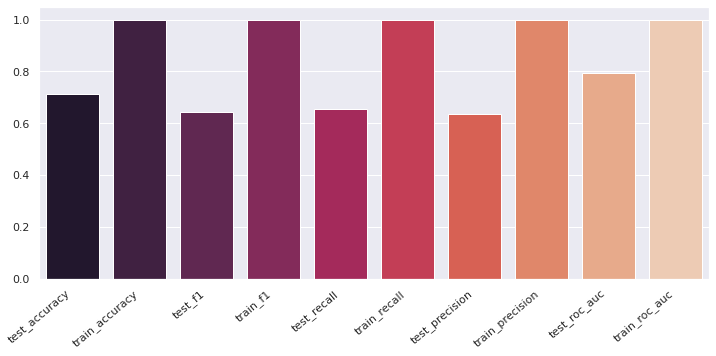

In [ ]:
vis_metrics_model(metrics_ada)


* A acurácia obteve-se um valor de para teste de 0.71 e 1.0 para o valor de treino. 
* A precisão obteve um resultado de 0.63 de treino e 1.0 de teste.
* Recall apresentou resultados de 0.65 para teste e 1.0 para treino.
* F1-Score obteve resultados de 0.64 para teste e de 1.0 para treino.
* Os resultados obtidos de reteste são proximos a do modelo de teste.

### KNN

In [ ]:
metrics_knn = cross_validate(model_knn, x_train_fold_two, y_train_fold_two, 
                             scoring=scoring, cv=cv, 
                             return_train_score=True,
                             return_estimator=True)


In [ ]:
sorted(metrics_knn.keys())


['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_accuracy',
 'train_f1',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [ ]:
model_knn = get_model_fit(metrics_knn)
model_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
print_metrics_models(metrics_knn)

fit_time  =  2.7252065658569338
score_time  =  5.526074743270874
test_accuracy  =  0.7252647417660925
train_accuracy  =  0.8523033246576672
test_f1  =  0.6688404890572555
train_f1  =  0.8214630823594439
test_recall  =  0.6949367149360979
train_recall  =  0.85108752063304
test_precision  =  0.6446499852319192
train_precision  =  0.7938320584060147
test_roc_auc  =  0.7900321576371857
train_roc_auc  =  0.9315432998736201


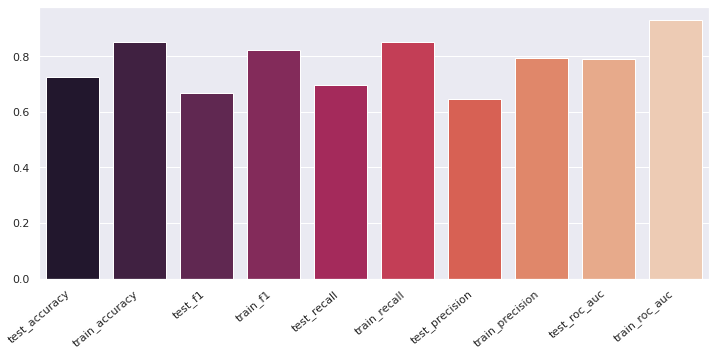

In [ ]:
vis_metrics_model(metrics_knn)

* A acurácia obteve-se um valor de para teste de 0.73 e 0.85 para o valor de treino. 
* A precisão obteve um resultado de 0.64 de treino e 0.79 de teste.
* Recall apresentou resultados de 0.69 para teste e 0.85 para treino.
* F1-Score obteve resultados de 0.67 para teste e de 0.82 para treino.
* Em geral, os resultados obtidos de reteste são próximos a do modelo de teste, somente os valores de teste de acurácia que foram muito diferentes.